In [ ]:
import sys
import torch
import os
HOME = os.getcwd()
print(f"Python version: {sys.version}, {sys.version_info} ")
print(f"Pytorch version: {torch.__version__} ")

In [ ]:
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
!ls

In [ ]:
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt

In [ ]:
!python detect.py --weights yolov7.pt --conf 0.35 --source test_v.mp4

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch

model = torch.hub.load('WongKinYiu/yolov7', 'custom', "yolov7.pt", force_reload=True, trust_repo=True)

In [ ]:
from dataclasses import dataclass
@dataclass(frozen=True)
class VideoConfig:
    fps: float
    width: int
    height: int

def get_video_writer(target_video_path: str, video_config: VideoConfig) -> cv2.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv2.VideoWriter(
        target_video_path, 
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
        fps=video_config.fps, 
        frameSize=(video_config.width, video_config.height), 
        isColor=True
    )

video_config = VideoConfig(
    fps=30, 
    width=1280, 
    height=720)
video_writer = get_video_writer(
    target_video_path="cica.mp4", 
    video_config=video_config)

In [ ]:
import cv2
from typing import Generator
def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


In [ ]:
frame_iterator = iter(generate_frames(video_file="test_v.mp4"))

In [ ]:
from tqdm.notebook import tqdm
parameters_shitomasi = dict(maxCorners=100, qualityLevel=0.3, minDistance=7)

parameters_shitomasi = dict(maxCorners=100, qualityLevel=0.3, minDistance=7)
parameter_lucas_kanade = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

for frame in tqdm(frame_iterator):
  results = model(frame)
  players_center = []
  for x_min, y_min, x_max, y_max, confidence, class_id in results.pred[0].cpu().numpy():
    print(x_min, y_min, x_max - x_min, y_max - y_min) # width height
    print("center", x_min + (x_max - x_min) / 2, y_min + (y_max - y_min) / 2)

In [ ]:
%cd yolov7


In [ ]:
import cv2
# Create a VideoCapture object to read from the video file
cap = cv2.VideoCapture('test_v.mp4')

# Read the first frame from the video
ret, frame = cap.read()

# Select the region of interest (ROI) in the first frame using a bounding box
bbox = cv2.selectROI('frame', frame)

# Initialize the tracker with the first frame and the ROI
tracker = cv2.TrackerLK_create()
tracker.init(frame, bbox)

# Define the video writer to save the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

# Loop through the video frames and track the object using optical flow
while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # If the frame cannot be read, break out of the loop
    if not ret:
        break

    # Track the object in the current frame using optical flow
    ret, bbox = tracker.update(frame)

    # If the tracker was successful, draw a bounding box around the tracked object
    if ret:
        x, y, w, h = [int(i) for i in bbox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Write the current frame with the bounding box to the output video
    out.write(frame)

    # Display the current frame with the bounding box around the tracked object (optional)
    # cv2.imshow('frame', frame)

    # Wait for a key press and exit if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the VideoCapture object, the output video, and close all windows (if any)
cap.release()
out.release()
cv2.destroyAllWindows()


In [ ]:
!ls

In [ ]:
import numpy as np
import cv2
  
cap = cv2.VideoCapture('test_v.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
out = cv2.VideoWriter('output_video.mp4', fourcc=fourcc, fps=fps, frameSize=(width, height), isColor=True) # Change the output file extension to .mp4
# params for corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
  
# Parameters for lucas kanade optical flow
lk_params = dict( winSize = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
                              10, 0.03))
  
# Create some random colors
color = np.random.randint(0, 255, (100, 3))
  
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame,
                        cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None,
                             **feature_params)
  
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
  
while(1):
      
    ret, frame = cap.read()
    frame_gray = cv2.cvtColor(frame,
                              cv2.COLOR_BGR2GRAY)
  
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray,
                                           frame_gray,
                                           p0, None,
                                           **lk_params)
  
    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]
  
    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, 
                                       good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (a, b), (c, d),
                        color[i].tolist(), 2)
          
        frame = cv2.circle(frame, (a, b), 5,
                           color[i].tolist(), -1)
          
    img = cv2.add(frame, mask)
  
    cv2.imshow('frame', img)
      
    k = cv2.waitKey(25)
    if k == 27:
        break
  
    # Updating Previous frame and points 
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)
  
cv2.destroyAllWindows()
cap.release()

In [ ]:
# get the code 
!git clone https://github.com/autonomousvision/unimatch
%cd /content/unimatch
# dependencies
!bash pip_install.sh
# check env
import torch

print('PyTorch version: %s' % torch.__version__)

if not torch.cuda.is_available():
  print('Running on CPU')
else:
  print('Runing on GPU %s' % torch.cuda.get_device_name())

# we assume the downloaded model weights are located under the pretrained directory.
%mkdir pretrained

# we provide a large number of model weights with different speed-accuracy trade-off trained on different datasets for downloading: 
# https://github.com/autonomousvision/unimatch/blob/master/MODEL_ZOO.md
# download example weights for flow, stereo and depth
!wget -P pretrained https://s3.eu-central-1.amazonaws.com/avg-projects/unimatch/pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth
!wget -P pretrained https://s3.eu-central-1.amazonaws.com/avg-projects/unimatch/pretrained/gmflow-scale2-regrefine6-kitti15-25b554d7.pth
!wget -P pretrained https://s3.eu-central-1.amazonaws.com/avg-projects/unimatch/pretrained/gmstereo-scale2-regrefine3-resumeflowthings-middleburyfthighres-a82bec03.pth
!wget -P pretrained https://s3.eu-central-1.amazonaws.com/avg-projects/unimatch/pretrained/gmdepth-scale1-regrefine1-resumeflowthings-scannet-90325722.pth


In [ ]:
!CUDA_VISIBLE_DEVICES=0 python main_flow.py \
--inference_video demo/kitti.mp4 \
--resume pretrained/gmflow-scale2-regrefine6-kitti15-25b554d7.pth \
--output_path output/kitti \
--padding_factor 32 \
--upsample_factor 4 \
--num_scales 2 \
--attn_splits_list 2 8 \
--corr_radius_list -1 4 \
--prop_radius_list -1 1 \
--reg_refine \
--num_reg_refine 6 \
--save_video \
--concat_flow_img

In [ ]:
import cv2
import numpy as np
import torch


cap = cv2.VideoCapture('test_v.mp4')
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

img = model(prev_frame)
print(img)

In [ ]:
!pip install opencv-python

In [ ]:
!git clone https://github.com/chuanenlin/optical-flow.git

In [ ]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow
# Parameters for Shi-Tomasi corner detection
feature_params = dict(maxCorners = 300, qualityLevel = 0.2, minDistance = 2, blockSize = 7)
# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize = (15,15), maxLevel = 2, criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
# The video feed is read in as a VideoCapture object
cap = cv.VideoCapture("test_v.mp4")
# Variable for color to draw optical flow track
color = (0, 255, 0)
# ret = a boolean return value from getting the frame, first_frame = the first frame in the entire video sequence
ret, first_frame = cap.read()
# Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)

fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter('output.mp4', fourcc, cap.get(cv.CAP_PROP_FPS), (int(cap.get(cv.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))))
prev = cv.goodFeaturesToTrack(prev_gray, mask = None, **feature_params)
mask = np.zeros_like(first_frame)

while(cap.isOpened()):
    # ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
    ret, frame = cap.read()
    # Converts each frame to grayscale - we previously only converted the first frame to grayscale
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    next, status, error = cv.calcOpticalFlowPyrLK(prev_gray, gray, prev, None, **lk_params)

    # Selects good feature points for previous position
    good_old = prev[status == 1]
    # Selects good feature points for next position
    good_new = next[status == 1]
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        # Returns a contiguous flattened array as (x, y) coordinates for new point
      a, b = new.ravel().astype(int)
        # Returns a contiguous flattened array as (x, y) coordinates for old point
      c, d = old.ravel().astype(int)
        # Draws line between new and old position with green color and 2 thickness
      mask = cv.line(mask, (a, b), (c, d), color, 2)
        # Draws filled circle (thickness of -1) at new position with green color and radius of 3
      frame = cv.circle(frame, (a, b), 3, color, -1)
    output = cv.add(frame, mask)
    # Visualizes checkpoint 2
    # Updates previous frame
    prev_gray = gray.copy()
    prev = good_new.reshape(-1, 1, 2)

    # cv2_imshow(output)
    out.write(output)


    # Frames are read by intervals of 10 milliseconds. The programs breaks out of the while loop when the user presses the 'q' key
    if cv.waitKey(10) & 0xFF == ord('q'):
        break
# The following frees up resources and closes all windows
cap.release()
out.release()
cv.destroyAllWindows()

In [ ]:
out.release()

In [ ]:
import numpy as np
import cv2

# # Load the image
img = cv2.imread('test2.jpg')
# # Extract the red and near-infrared channels from the image
red_channel = img[:,:,1]
nir_channel = img[:,:,2]

# # Convert the channels to floats and calculate the NDVI
red_channel = red_channel.astype(float)
nir_channel = nir_channel.astype(float)
ndvi = (nir_channel - red_channel) / (nir_channel + red_channel)

# # Normalize the NDVI values to the range [0, 255]
ndvi_normalized = cv2.normalize(ndvi, None, 0, 255, cv2.NORM_MINMAX)

# # Save the NDVI image to a file
# cv2.imwrite('ndvi_image.jpg', ndvi)
cv2_imshow(ndvi_normalized)


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
# Load the RGB image
rgb_img = cv2.imread('test.avif')

# Convert the RGB image to floating point values between 0 and 1
rgb_img_float = rgb_img.astype(np.float32) / 255.0

# Calculate an estimate of the NIR reflectance value
nir_estimate = (rgb_img_float[:,:,1] + rgb_img_float[:,:,0]) / 2.0

# Calculate NDVI
ndvi = (nir_estimate - rgb_img_float[:,:,2]) / (nir_estimate + rgb_img_float[:,:,2])

# Display the NDVI image
cv2_imshow(ndvi)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
from collections import deque

def find_stable_matchings(men_prefs, women_prefs):
    """
    Finds all stable matchings from a set of men and women with preference lists.
    """
    num_people = len(men_prefs)
    free_men = set(range(num_people))
    unmatched_women = set(range(num_people))
    current_matchings = [-1] * num_people  # -1 represents no current matching
    proposed_to = [0] * num_people  # index of the last proposal made by each man
    women_prefs_ranked = [deque(prefs) for prefs in women_prefs]  # ranked preference list of each woman
    
    def propose(m):
        """
        Proposes to the highest-ranked woman who has not yet rejected the man.
        """
        w = men_prefs[m][proposed_to[m]]
        proposed_to[m] += 1
        if current_matchings[w] == -1:
            current_matchings[w] = m
            free_men.remove(m)
            if unmatched_women[w] is not None:
              unmatched_women.remove(w)
            return True
        else:
            m_prime = current_matchings[w]
            if women_prefs_ranked[w].index(m) < women_prefs_ranked[w].index(m_prime):
                current_matchings[w] = m
                free_men.remove(m)
                free_men.add(m_prime)
                return True
            else:
                return False
    
    def unpropose(m):
        """
        Removes the current matching between the man and his partner.
        """
        w = current_matchings[m]
        current_matchings[m] = -1
        free_men.add(m)
        unmatched_women.add(w)
    
    def find_all_matchings():
        """
        Recursively finds all stable matchings using backtracking.
        """
        if not unmatched_women:
            yield list(current_matchings)
        else:
            w = unmatched_women.pop()
            for m in women_prefs[w]:
                if m in free_men:
                    if propose(m):
                        yield from find_all_matchings()
                        unpropose(m)
                elif women_prefs_ranked[w].index(m) < women_prefs_ranked[w].index(current_matchings[m]):
                    old_partner = current_matchings[m]
                    unpropose(old_partner)
                    if propose(m):
                        yield from find_all_matchings()
                        unpropose(m)
                    current_matchings[m] = old_partner
                    current_matchings[old_partner] = m
    
    yield from find_all_matchings()


men_prefs = [[1, 0, 2], [0, 1, 2], [2, 1, 0]]
women_prefs = [[0, 1, 2], [1, 0, 2], [2, 0, 1]]

for matching in find_stable_matchings(men_prefs, women_prefs):
    print(matching)


In [ ]:
# get the code 
!git clone https://github.com/autonomousvision/unimatch

In [ ]:
%cd /content/unimatch

In [ ]:
# dependencies
!bash pip_install.sh

In [ ]:
# check env
import torch

print('PyTorch version: %s' % torch.__version__)

if not torch.cuda.is_available():
  print('Running on CPU')
else:
  print('Runing on GPU %s' % torch.cuda.get_device_name())

In [ ]:
# we assume the downloaded model weights are located under the pretrained directory.
# %mkdir pretrained# we provide a large number of model weights with different speed-accuracy trade-off trained on different datasets for downloading: 
# https://github.com/autonomousvision/unimatch/blob/master/MODEL_ZOO.md
# download example weights for flow, stereo and depth
!wget -P pretrained https://s3.eu-central-1.amazonaws.com/avg-projects/unimatch/pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth
!wget -P pretrained https://s3.eu-central-1.amazonaws.com/avg-projects/unimatch/pretrained/gmflow-scale2-regrefine6-kitti15-25b554d7.pth
!wget -P pretrained https://s3.eu-central-1.amazonaws.com/avg-projects/unimatch/pretrained/gmstereo-scale2-regrefine3-resumeflowthings-middleburyfthighres-a82bec03.pth
!wget -P pretrained https://s3.eu-central-1.amazonaws.com/avg-projects/unimatch/pretrained/gmdepth-scale1-regrefine1-resumeflowthings-scannet-90325722.pth

In [ ]:
import cv2
vidcap = cv2.VideoCapture('./unimatch/demo/test_rov.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("./unimatch/demo/foot/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

In [ ]:
# inference on posed images
# script from: https://github.com/autonomousvision/unimatch/blob/master/scripts/gmdepth_demo.sh
!python main_depth.py \
--inference_dir demo/foot \
--output_path output/foot \
--resume pretrained/gmdepth-scale1-regrefine1-resumeflowthings-scannet-90325722.pth


In [ ]:
# inference on video
# script from: https://github.com/autonomousvision/unimatch/blob/master/scripts/gmflow_demo.sh
!python main_flow.py \
--inference_video demo/test_rov.mp4 \
--resume pretrained/gmflow-scale2-regrefine6-kitti15-25b554d7.pth \
--output_path output/foci \
--padding_factor 32 \
--upsample_factor 4 \
--num_scales 2 \
--attn_splits_list 2 8 \
--corr_radius_list -1 4 \
--prop_radius_list -1 1 \
--reg_refine \
--num_reg_refine 6 \
--save_video \
--concat_flow_img

In [ ]:
%rm -rf output/foci
# !ls

In [ ]:
import cv2
import os

# Set the directory containing the frames
frame_dir = 'output/foci'

# Set the output video file name and frame rate
output_file = 'output.mp4'
fps = 30

# Get the list of frames in the directory
frames = os.listdir(frame_dir)
frames.sort()

# Set the video dimensions to match the first frame
frame_path = os.path.join(frame_dir, frames[0])
frame = cv2.imread(frame_path)
height, width, _ = frame.shape

# Create the video writer object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

# Write each frame to the video file
for frame_name in frames:
    frame_path = os.path.join(frame_dir, frame_name)
    frame = cv2.imread(frame_path)
    out.write(frame)

# Release the video writer object
out.release()


In [ ]:
!pip install flow_vis

In [ ]:
!pip install globalVariables

In [ ]:
!git clone https://github.com/princeton-vl/RAFT.git


In [ ]:
!wget https://www.dropbox.com/s/4j4z58wuv8o0mfz/models.zip
!unzip models.zip

In [ ]:
pip install RAFT

In [ ]:
!python RAFT/core/raft.py --model=models/raft-things.pth --input=test_rov.mp4 --output=output_flow.mp4

In [ ]:
%cd RAFT

In [ ]:
pip install pytorch=1.6.0 torchvision=0.7.0 cudatoolkit=10.1 matplotlib tensorboard scipy opencv -c pytorch

In [ ]:
!python demo.py --model=./models/raft-things.pth --path=demo-frames

In [ ]:
!zip -r /content/foot.zip /content/unimatch/demo/foot

In [ ]:
from google.colab import files
files.download("/content/foot.zip")

In [ ]:
!git clone https://github.com/uzh-rpg/E-RAFT.git

In [ ]:
%cd E-RAFT

In [ ]:
!python download_dsec_test.py OUTPUT_DIRECTORY

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
# Load two consecutive frames
frame1 = cv2.imread('frame0.jpg')
frame2 = cv2.imread('frame1.jpg')

# Convert frames to grayscale
prev_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
next_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

# Calculate dense optical flow using Farneback method
flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

# Compute magnitude and angle of the optical flow vectors
magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

# Convert angle to hue, and magnitude to value in HSV color space
hsv = np.zeros_like(frame1)
hsv[..., 0] = angle * 180 / np.pi / 2
hsv[..., 1] = 255
hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

# Convert HSV to BGR and show the resulting image
flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
cv2_imshow(flow_rgb)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np

# Load video
cap = cv2.VideoCapture('test_rov.mp4')

# Read first frame
ret, frame1 = cap.read()

# Convert first frame to grayscale
prev_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

# Define parameters for Farneback method
pyr_scale = 0.5
levels = 3
winsize = 15
iterations = 3
poly_n = 5
poly_sigma = 1.2
flags = 0

# Process video frame by frame
while True:
    # Read next frame
    ret, frame2 = cap.read()
    if not ret:
        break

    # Convert next frame to grayscale
    next_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Calculate dense optical flow using Farneback method
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags)

    # Compute magnitude and angle of the optical flow vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Convert angle to hue, and magnitude to value in HSV color space
    hsv = np.zeros_like(frame1)
    hsv[..., 0] = angle * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # Convert HSV to BGR and show the resulting image
    flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    cv2_imshow(flow_rgb)

    # Wait for key press and break if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Update previous frame
    prev_gray = next_gray

# Release video capture and close all windows
cap.release()
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np

# Load video
cap = cv2.VideoCapture('test_v.mp4')

# Define output video properties
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

# Create output video writer
out = cv2.VideoWriter('output.mp4', fourcc, fps, frame_size)

# Read first frame
ret, frame1 = cap.read()

# Convert first frame to grayscale
prev_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

# Define parameters for Farneback method
pyr_scale = 0.5
levels = 3
winsize = 15
iterations = 3
poly_n = 5
poly_sigma = 1.2
flags = 0

# Process video frame by frame
while True:
    # Read next frame
    ret, frame2 = cap.read()
    if not ret:
        break

    # Convert next frame to grayscale
    next_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    matrix = np.zeros_like(frame2, dtype=np.uint8)

    # Calculate dense optical flow using Farneback method
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags)

    # Compute magnitude and angle of the optical flow vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Convert angle to hue, and magnitude to value in HSV color space
    hsv = np.zeros_like(frame1)
    hsv[..., 0] = angle * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # Convert HSV to BGR and overlay the resulting flow image onto the original frame
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    overlay = cv2.addWeighted(frame2, 0.5, flow_bgr, 0.5, 0)

    # Write the resulting frame to the output video
    out.write(overlay)

    # Show the resulting frame in a window
    # cv2.imshow('Optical flow', overlay)

    # Wait for key press and break if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Update previous frame
    prev_gray = next_gray

# Release video capture, writer, and close all windows
cap.release()
out.release()
cv2.destroyAllWindows()


In [ ]:
merge with yolo

In [ ]:
import cv2
import numpy as np
import torch
from google.colab.patches import cv2_imshow

# Load video
cap = cv2.VideoCapture('test_rov.mp4')
#model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
(W, H) = (None, None)
# Define output video properties
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

# Create output video writer
out = cv2.VideoWriter('output.mp4', fourcc, fps, frame_size)

# Read first frame
ret, frame1 = cap.read()

res = model(frame1)

# Convert first frame to grayscale
prev_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

# Define parameters for Farneback method
pyr_scale = 0.5
levels = 3
winsize = 15
iterations = 3
poly_n = 5
poly_sigma = 1.2
flags = 0

# Process video frame by frame
while True:
    # Read next frame
    ret, frame2 = cap.read()
    if not ret:
        break
    if W is None or H is None:
        (H, W) = frame2.shape[:2]
    # Convert next frame to grayscale
    next_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    matrix = np.zeros_like(frame2, dtype=np.uint8)
    boxes = []
    confidences = []
    # model prediction
    pred = model(frame2)
    for output in pred.xyxy[0].cpu():
        if float(output[4]) > 0.5:
          box = output[0:4] #* np.array([W, H, W, H])
          (centerX, centerY, width, height) = box.numpy().astype("int")
          x = int(centerX)
          y = int(centerY)
          # x = int(centerX - (width / 2))
          # y = int(centerY - (height / 2))
          boxes.append([x, y, int(width), int(height)])
          confidences.append(float(output[4]))
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)
  
    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            color = (0, 255, 0)  # green
            cv2.rectangle(frame2, (x, y), (x + w, y + h), color, 2)
            text = "{}".format('Object')
            cv2.putText(frame2, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            # Apply optical flow to the bounding box region
            # print(prev_gray[y:y+h, x:x+w])
            roi_gray = prev_gray[y:y+h, x:x+w]
            roi_next_gray = next_gray[y:y+h, x:x+w]
            # print(x)
            # print(y)
            # print(roi_gray)
            # print(roi_next_gray)
            flow = cv2.calcOpticalFlowFarneback(roi_gray, roi_next_gray, None, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags)
            
            magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            hsv = np.zeros_like(roi_gray)

            hsv[..., 0] = (angle * 180 / np.pi / 2)[..., 0] #angle * 180 / np.pi / 2
            hsv[..., 1] = 255
            hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)[..., 2] # cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
            # print(hsv)
            # flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
            flow_bgr = cv2.cvtColor(cv2.merge([hsv, hsv, hsv]), cv2.COLOR_HSV2BGR)

            overlay = cv2.addWeighted(frame2[y:y+h, x:x+w], 0.5, flow_bgr, 0.5, 0)
            frame2[y:y+h, x:x+w] = overlay
# Write the resulting frame to the output video
    out.write(frame2)
    # cv2_imshow(frame2)
    # Show the resulting frame in a window
    # cv2.imshow('Optical flow', frame2)
    # Wait for key press and break if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    # Update previous frame
    prev_gray = next_gray
# Release video capture, writer, and close all windows
cap.release()
out.release()
cv2.destroyAllWindows()


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
cap = cv2.VideoCapture('test_rov.mp4')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

out = cv2.VideoWriter('output.mp4', fourcc, fps, frame_size)

ret, frame1 = cap.read()

cv2.imwrite("frame.png", frame1) 

In [ ]:
image = cv2.imread('frame.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:

masks = mask_generator.generate(image)

In [ ]:
print(len(masks))
print(masks[0].keys())

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [ ]:
!git clone https://github.com/hkchengrex/XMem.git
%cd XMem
!pip install opencv-python
!pip install -U numpy
!pip install -r requirements.txt

In [ ]:
!wget -P ./saves/ https://github.com/hkchengrex/XMem/releases/download/v1.0/XMem.pth

In [ ]:
# %cd ..
import os
from os import path
from argparse import ArgumentParser
import shutil
device='cuda'
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image

from inference.data.test_datasets import LongTestDataset, DAVISTestDataset, YouTubeVOSTestDataset
from inference.data.mask_mapper import MaskMapper
from model.network import XMem
from inference.inference_core import InferenceCore

from progressbar import progressbar

torch.set_grad_enabled(False)

# default configuration
config = {
    'top_k': 30,
    'mem_every': 5,
    'deep_update_every': -1,
    'enable_long_term': True,
    'enable_long_term_count_usage': True,
    'num_prototypes': 128,
    'min_mid_term_frames': 5,
    'max_mid_term_frames': 10,
    'max_long_term_elements': 10000,
}

network = XMem(config, './XMem/saves/XMem.pth').eval().to(device)

In [ ]:
%cd ..

In [ ]:
# %cd content/
video_name = 'test_rov.mp4'
mask_name = 'kep.png'

In [ ]:
# Image.open(mask_name)
# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
mask = np.array(Image.open(mask_name))
print(np.unique(mask))
num_objects = len(np.unique(mask)) - 1

In [ ]:
mask.shape

In [ ]:
import cv2
from inference.interact.interactive_utils import image_to_torch, index_numpy_to_one_hot_torch, torch_prob_to_numpy_mask, overlay_davis

torch.cuda.empty_cache()

processor = InferenceCore(network, config=config)
processor.set_all_labels(range(1, num_objects+1)) # consecutive labels
cap = cv2.VideoCapture(video_name)

# You can change these two numbers
frames_to_propagate = 200
visualize_every = 20

current_frame_index = 0

# mask = mask[..., :3]

with torch.cuda.amp.autocast(enabled=True):
  while (cap.isOpened()):
    # load frame-by-frame
    _, frame = cap.read()
    if frame is None or current_frame_index > frames_to_propagate:
      break

    # convert numpy array to pytorch tensor format
    frame_torch, _ = image_to_torch(frame, device=device)
    if current_frame_index == 0:
      # initialize with the mask
      
      
      mask_torch = index_numpy_to_one_hot_torch(mask, num_objects+1).to(device)
      # the background mask is not fed into the model
      prediction = processor.step(frame_torch, mask_torch[1:])
    else:
      # propagate only
      prediction = processor.step(frame_torch)

    # argmax, convert to numpy
    prediction = torch_prob_to_numpy_mask(prediction)

    if current_frame_index % visualize_every == 0:
      visualization = overlay_davis(frame, prediction)
      display(Image.fromarray(visualization))

    current_frame_index += 1

In [ ]:
import cv2
import threading

# Create a VideoCapture object for each video
cap1 = cv2.VideoCapture('output_1.mp4')
cap2 = cv2.VideoCapture('output_2.mp4')
cap3 = cv2.VideoCapture('output_3.mp4')
cap4 = cv2.VideoCapture('output_4.mp4')

# Set the width and height of the video frames
frame_width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a window to display the videos
cv2.namedWindow('Videos', cv2.WINDOW_NORMAL)

# Define a function to play a video in a separate thread
def play_video(cap):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow('Videos', frame)
        if cv2.waitKey(1) == ord('q'):
            break

# Create a separate thread to play each video
thread1 = threading.Thread(target=play_video, args=(cap1,))
thread2 = threading.Thread(target=play_video, args=(cap2,))
thread3 = threading.Thread(target=play_video, args=(cap3,))
thread4 = threading.Thread(target=play_video, args=(cap4,))

# Start the threads
thread1.start()
thread2.start()
thread3.start()
thread4.start()

# Wait for the threads to finish
thread1.join()
thread2.join()
thread3.join()
thread4.join()

# Release the VideoCapture objects and destroy the window
cap1.release()
cap2.release()
cap3.release()
cap4.release()
cv2.destroyAllWindows()


In [ ]:
!wget https://github.com/ultralytics/yolov5/releases/download/v5.0/yolov5s.pt


In [ ]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5s.pt')


In [ ]:
import cv2

cap = cv2.VideoCapture('test_rov.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    results = model(frame, size=416)
    print(results.pred)
    print(results.names)
    print(results.)
    break
    # ball_results = results.xyxy[results.names.index('football')]
    # if len(ball_results) > 0:
        # bbox = ball_results[0][0:4]
        # cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
    # cv2.imshow('frame', frame)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


In [ ]:
import cv2
cap = cv2.VideoCapture('video.mp4')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

# out = cv2.VideoWriter('output.mp4', fourcc, fps, frame_size)

ret, frame1 = cap.read()

cv2.imwrite("frame_elso.png", frame1) 

In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow
# Load the image
img = cv2.imread('football.png')
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
classes = []
with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# Define the input size of the YOLO model
input_size = (416, 416)

# Resize the image to the input size of the YOLO model
resized_img = cv2.resize(img, input_size)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cv2_imshow(gray)

In [ ]:
# Initialize the SIFT feature detector
sift = cv2.SIFT_create()

ret, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

# Detect keypoints and extract descriptors
kp, des = sift.detectAndCompute(gray, mask)

# Draw the keypoints on the image
# img_kp = cv2.drawKeypoints(img, kp, None)
img_kp = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# Display the image with keypoints
cv2_imshow(img_kp)

In [ ]:
#XMEM hasznald itt
!git clone https://github.com/hkchengrex/XMem.git
%cd XMem
!pip install opencv-python
!pip install -U numpy
!pip install -r requirements.txt

In [ ]:
!ls

In [ ]:
%cd XMem
!pip install opencv-python
!pip install -U numpy
!pip install -r requirements.txt

In [ ]:
!wget -P ./saves/ https://github.com/hkchengrex/XMem/releases/download/v1.0/XMem.pth

In [ ]:
!nvidia-smi

import torch

if torch.cuda.is_available():
  print('Using GPU')
  device = 'cuda'
else:
  print('CUDA not available. Please connect to a GPU instance if possible.')
  device = 'cpu'

In [ ]:
import os
from os import path
from argparse import ArgumentParser
import shutil

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image

from inference.data.test_datasets import LongTestDataset, DAVISTestDataset, YouTubeVOSTestDataset
from inference.data.mask_mapper import MaskMapper
from model.network import XMem
from inference.inference_core import InferenceCore

from progressbar import progressbar

torch.set_grad_enabled(False)

# default configuration
config = {
    'top_k': 30,
    'mem_every': 5,
    'deep_update_every': -1,
    'enable_long_term': True,
    'enable_long_term_count_usage': True,
    'num_prototypes': 128,
    'min_mid_term_frames': 5,
    'max_mid_term_frames': 10,
    'max_long_term_elements': 10000,
}

network = XMem(config, './saves/XMem.pth').eval().to(device)


In [ ]:

!wget -O video.mp4 https://user-images.githubusercontent.com/7107196/177661140-f690156b-1775-4cd7-acd7-1738a5c92f30.mp4
!wget -O first_frame.png https://i.imgur.com/3ueaiBA.png

video_name = 'video.mp4'
mask_name = 'first_frame.png'

In [ ]:
from IPython.display import HTML
from base64 import b64encode
data_url = "data:video/mp4;base64," + b64encode(open(video_name, 'rb').read()).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
import IPython.display
IPython.display.Image('first_frame.png', width=400)

In [ ]:
#nocvert mask to np array
mask = np.array(Image.open(mask_name))
print(np.unique(mask))
num_objects = len(np.unique(mask)) - 1

In [ ]:
import matplotlib.pyplot as plt

# Load mask image
mask = np.array(Image.open(mask_name))

# Get unique pixel values in the mask
unique_values = np.unique(mask)

# Set the color map
cmap = plt.cm.get_cmap('jet', len(unique_values))

# Visualize the mask array using the color map
plt.imshow(mask, cmap=cmap, vmin=unique_values[0], vmax=unique_values[-1])
plt.colorbar()

# Show the plot
plt.show()


In [ ]:
import math

def distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def perimeter_of_quadrilateral(a, b, c, d):
    x1, y1 = a
    x2, y2 = b
    x3, y3 = c
    x4, y4 = d
    
    AB = distance(x1, y1, x2, y2)
    BC = distance(x2, y2, x3, y3)
    CD = distance(x3, y3, x4, y4)
    DA = distance(x4, y4, x1, y1)
    
    perimeter = AB + BC + CD + DA
    
    return perimeter

arr = np.array([
    [0,0,4,4,4,0,0,0],
    [0,0,4,4,4,4,4,0],
    [0,4,4,4,4,4,0,0],
    [0,1,1,1,1,1,1,1],
    [1,1,1,1,1,0,0,0],
    [0,0,1,0,1,1,1,0]
])
# expected output row: first oc 0 and last oc: 2
# expected output closest to zero is [2,1] closest to the end of the row: [1,6]

# Find the (x, y) coordinates of the first occurrence of 1
num_object = [1,4]
for obj_id in num_object:
  first_occurrence_idx = np.argmax(arr == obj_id)
  first_occurrence_coordinates = np.unravel_index(first_occurrence_idx, arr.shape)

  # Find the (x, y) coordinates of the last occurrence of 1
  last_occurrence_idx = np.argwhere(arr == obj_id)[-1]
  last_occurrence_coordinates = tuple(last_occurrence_idx)

  # so far so good

  coordinates = np.argwhere(arr == obj_id)

  min_y_idx_in_coordinates = np.argmin(coordinates[:, 1])
  max_y_idx_in_coordinates = np.argmax(coordinates[:, 1])

  min_y_element = coordinates[min_y_idx_in_coordinates]
  max_y_element = coordinates[max_y_idx_in_coordinates]

  # Calculate the distances from the 0-th index

  print("id", obj_id)
  print(f"First occurrence coordinates: {first_occurrence_coordinates}")
  print(f"Last occurrence coordinates: {last_occurrence_coordinates}")

  print("Smallest y element:", min_y_element)
  print("Largest y element:", max_y_element)

  print(first_occurrence_coordinates, last_occurrence_coordinates,min_y_element,max_y_element )
  a,b,c,d = first_occurrence_coordinates, last_occurrence_coordinates, min_y_element, max_y_element
  #  kiveszem az x min es y min es kiveszem a max x es max y?
  max_x = max(a[0], b[0], c[0], d[0])
  min_x = min(a[0], b[0], c[0], d[0])
  max_y = max(a[1], b[1], c[1], d[1])
  min_y = min(a[1], b[1], c[1], d[1])

  print("Max x value:", max_x)
  print("Min x value:", min_x)
  print("Max y value:", max_y)
  print("Min y value:", min_y)
def area_of_quadrilateral(a, b, c, d):
    x1, y1 = a
    x2, y2 = b
    x3, y3 = c
    x4, y4 = d
    
    area = 0.5 * abs((x1*y2 + x2*y3 + x3*y4 + x4*y1) - (y1*x2 + y2*x3 + y3*x4 + y4*x1))
    
    return area


In [ ]:
import math

def distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def perimeter_of_quadrilateral(a, b, c, d):
    x1, y1 = a
    x2, y2 = b
    x3, y3 = c
    x4, y4 = d
    
    AB = distance(x1, y1, x2, y2)
    BC = distance(x2, y2, x3, y3)
    CD = distance(x3, y3, x4, y4)
    DA = distance(x4, y4, x1, y1)
    
    perimeter = AB + BC + CD + DA
    
    return perimeter

In [ ]:
import cv2
from inference.interact.interactive_utils import image_to_torch, index_numpy_to_one_hot_torch, torch_prob_to_numpy_mask, overlay_davis

torch.cuda.empty_cache()

processor = InferenceCore(network, config=config)
processor.set_all_labels(range(1, num_objects+1)) # consecutive labels
cap = cv2.VideoCapture(video_name)

# You can change these two numbers
frames_to_propagate = 200
visualize_every = 20

current_frame_index = 0

with torch.cuda.amp.autocast(enabled=True):
  while (cap.isOpened()):
    # load frame-by-frame
    _, frame = cap.read()
    if frame is None or current_frame_index > frames_to_propagate:
      break

    # convert numpy array to pytorch tensor format
    frame_torch, _ = image_to_torch(frame, device=device)
    if current_frame_index == 0:
      # initialize with the mask
      mask_torch = index_numpy_to_one_hot_torch(mask, num_objects+1).to(device)
      # the background mask is not fed into the model
      prediction = processor.step(frame_torch, mask_torch[1:])
    else:
      # propagate only
      prediction = processor.step(frame_torch)


    # print("elso",prediction)
    # argmax, convert to numpy
    prediction = torch_prob_to_numpy_mask(prediction)
    # x_s, y_s = prediction.shape
    # for x in range(x_s):
    #   for y in range(y_s):
    #     print(prediction[x,y], end="")
    #   print(end="\n")

    a,b,c,d = None, None, None, None
    permit = math.inf
    for obj_id in np.unique(mask)[1:]:
      first_occurrence_idx = np.argmax(prediction == obj_id)
      first_occurrence_coordinates = np.unravel_index(first_occurrence_idx, prediction.shape)

      # Find the (x, y) coordinates of the last occurrence of 1
      last_occurrence_idx = np.argwhere(prediction == obj_id)[-1]
      last_occurrence_coordinates = tuple(last_occurrence_idx)

      # so far so good

      coordinates = np.argwhere(prediction == obj_id)

      min_y_idx_in_coordinates = np.argmin(coordinates[:, 1])
      max_y_idx_in_coordinates = np.argmax(coordinates[:, 1])

      min_y_element = coordinates[min_y_idx_in_coordinates]
      max_y_element = coordinates[max_y_idx_in_coordinates]

      # Calculate the distances from the 0-th index

      # print("id", obj_id)
      # print(f"First occurrence coordinates: {first_occurrence_coordinates}")
      # print(f"Last occurrence coordinates: {last_occurrence_coordinates}")

      # print("Smallest y element:", min_y_element)
      # print("Largest y element:", max_y_element)
      quadrilateral = perimeter_of_quadrilateral(first_occurrence_coordinates, last_occurrence_coordinates, min_y_element, max_y_element)
      # print("permiter", quadrilateral)

      if quadrilateral < permit:
        a,b,c,d = first_occurrence_coordinates, last_occurrence_coordinates, min_y_element, max_y_element
        permit = quadrilateral
      # print(a,b,c,d)
    max_x = max(a[0], b[0], c[0], d[0])
    max_y = max(a[1], b[1], c[1], d[1])
    min_x = min(a[0], b[0], c[0], d[0])
    min_y = min(a[1], b[1], c[1], d[1])
      # print(tuple([min_x,min_y]), tuple([max_x,max_y]))
      # print(tuple([min_x,max_y]),tuple([max_x,min_y]))
    # print(tuple([max_y, min_x]),tuple([min_y, max_x]))
    frame_bbox = cv2.rectangle(frame,tuple([max_y, min_x]),tuple([min_y, max_x]), (0, 255, 0), 2)
      
    if current_frame_index % visualize_every == 0:
      visualization = overlay_davis(frame_bbox, prediction)
      display(Image.fromarray(visualization))

    current_frame_index += 1
    # break

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
%cd ..

In [ ]:
pip install git+https://github.com/facebookresearch/segment-anything.git

In [ ]:
!wget "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
image = cv2.imread('frame_elso.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
masks = mask_generator.generate(image)

In [ ]:
print(len(masks))
print(masks[0].keys())

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

# The collab can't hold this many masks

In [ ]:
# select frame instead
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [ ]:
!ls

In [ ]:
%cd ..

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
image = cv2.imread('frame_elso.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [ ]:
pip install git+https://github.com/facebookresearch/segment-anything.git

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
  predictor.set_image(image)

In [ ]:
input_point = np.array([[799, 553]])
input_label = np.array([1])

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [ ]:
dpi = 96
for i, (mask, score) in enumerate(zip(masks, scores)):
    # plt.figure(figsize=(10,10))
    fig = plt.figure(figsize=(1920/dpi, 1080/dpi), dpi=dpi)
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_points(input_point, input_label, plt.gca())
    # plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    # plt.show()  
    plt.savefig('foo.png',bbox_inches='tight')
    break
  

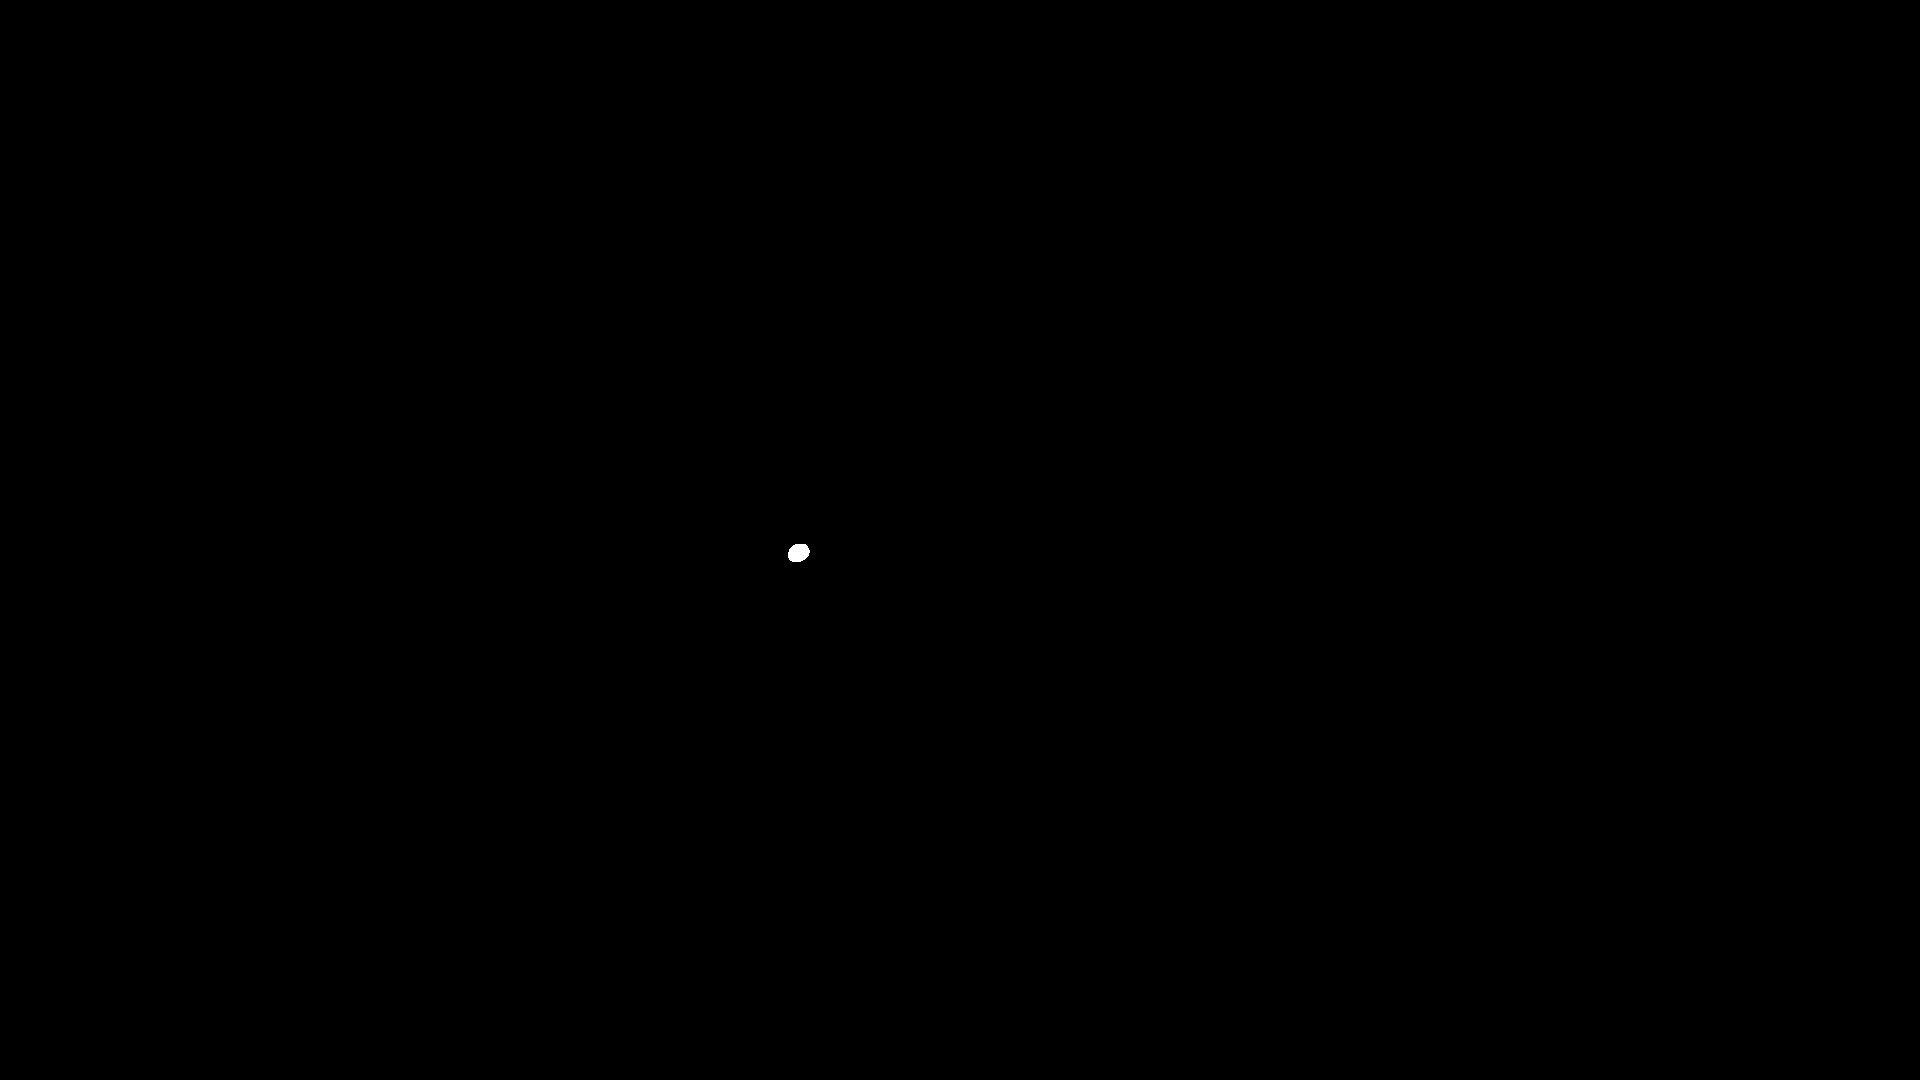

In [29]:
from PIL import Image
import numpy as np

# Open image
img = Image.open("frame_elso.png")


# Create mask around image
img_mask = Image.fromarray((mask * 255).astype(np.uint8), mode='L')
img_mask = img_mask.crop(img.getbbox())

# Show mask
img_mask.show()



In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [30]:
%cd XMem

/content/XMem


In [31]:
video_name = 'video.mp4'
mask_name = 'first_frame.png'



In [ ]:
from IPython.display import HTML
from base64 import b64encode
data_url = "data:video/mp4;base64," + b64encode(open(video_name, 'rb').read()).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [35]:
#nocvert mask to np array
mask = np.array(Image.open(mask_name))
print(mask)
print(np.unique(mask))
num_objects = len(np.unique(mask)) - 1
print(num_objects)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[  0 255]
1


In [33]:
import cv2
from inference.interact.interactive_utils import image_to_torch, index_numpy_to_one_hot_torch, torch_prob_to_numpy_mask, overlay_davis

torch.cuda.empty_cache()

processor = InferenceCore(network, config=config)
processor.set_all_labels(range(1, num_objects+1)) # consecutive labels
cap = cv2.VideoCapture(video_name)

# You can change these two numbers
frames_to_propagate = 200
visualize_every = 20

current_frame_index = 0

with torch.cuda.amp.autocast(enabled=True):
  while (cap.isOpened()):
    # load frame-by-frame
    _, frame = cap.read()
    if frame is None or current_frame_index > frames_to_propagate:
      break

    # convert numpy array to pytorch tensor format
    frame_torch, _ = image_to_torch(frame, device=device)
    if current_frame_index == 0:
      # initialize with the mask
      mask_torch = index_numpy_to_one_hot_torch(mask, num_objects+1).to(device)
      # the background mask is not fed into the model
      prediction = processor.step(frame_torch, mask_torch[1:])
    else:
      # propagate only
      prediction = processor.step(frame_torch)


    # print("elso",prediction)
    # argmax, convert to numpy
    prediction = torch_prob_to_numpy_mask(prediction)
    # x_s, y_s = prediction.shape
    # for x in range(x_s):
    #   for y in range(y_s):
    #     print(prediction[x,y], end="")
    #   print(end="\n")

    a,b,c,d = None, None, None, None
    permit = math.inf
    for obj_id in np.unique(mask)[1:]:
      first_occurrence_idx = np.argmax(prediction == obj_id)
      first_occurrence_coordinates = np.unravel_index(first_occurrence_idx, prediction.shape)

      # Find the (x, y) coordinates of the last occurrence of 1
      last_occurrence_idx = np.argwhere(prediction == obj_id)[-1]
      last_occurrence_coordinates = tuple(last_occurrence_idx)

      # so far so good

      coordinates = np.argwhere(prediction == obj_id)

      min_y_idx_in_coordinates = np.argmin(coordinates[:, 1])
      max_y_idx_in_coordinates = np.argmax(coordinates[:, 1])

      min_y_element = coordinates[min_y_idx_in_coordinates]
      max_y_element = coordinates[max_y_idx_in_coordinates]

      # Calculate the distances from the 0-th index

      # print("id", obj_id)
      # print(f"First occurrence coordinates: {first_occurrence_coordinates}")
      # print(f"Last occurrence coordinates: {last_occurrence_coordinates}")

      # print("Smallest y element:", min_y_element)
      # print("Largest y element:", max_y_element)
      quadrilateral = perimeter_of_quadrilateral(first_occurrence_coordinates, last_occurrence_coordinates, min_y_element, max_y_element)
      # print("permiter", quadrilateral)

      if quadrilateral < permit:
        a,b,c,d = first_occurrence_coordinates, last_occurrence_coordinates, min_y_element, max_y_element
        permit = quadrilateral
      # print(a,b,c,d)
    max_x = max(a[0], b[0], c[0], d[0])
    max_y = max(a[1], b[1], c[1], d[1])
    min_x = min(a[0], b[0], c[0], d[0])
    min_y = min(a[1], b[1], c[1], d[1])
      # print(tuple([min_x,min_y]), tuple([max_x,max_y]))
      # print(tuple([min_x,max_y]),tuple([max_x,min_y]))
    # print(tuple([max_y, min_x]),tuple([min_y, max_x]))
    frame_bbox = cv2.rectangle(frame,tuple([max_y, min_x]),tuple([min_y, max_x]), (0, 255, 0), 2)
      
    if current_frame_index % visualize_every == 0:
      visualization = overlay_davis(frame_bbox, prediction)
      display(Image.fromarray(visualization))

    current_frame_index += 1
    # break

RuntimeError: ignored